# PEFT

Сегодня LLM становятся незаменимым инструментом как для полноценного решения продуктовых задач, так и на промежуточных этапах, например, генерация разметки или создание синтетических датасетов. Обучение и дообучение таких моделей может быть ресурсозатратным, поэтому на зачастую полезно использовать Parameter-Efficient Fine-Tuning, PEFT.

PEFT позволяет адаптировать крупные языковые модели под конкретные задачи, внося минимальные изменения в архитектуру и обучаясь на сравнительно небольшом объёме данных. Ключевые методы – такие как адаптеры, LoRA или DoRA – демонстрируют высокую эффективность, позволяя достичь конкурентоспособной точности при низких затратах на вычислительные мощности.

Представьте, что ваша задача – определить тональность твитов. Твиты – короткие, насыщенные эмоциями и часто саркастичные сообщения, где традиционные модели могут давать сбои из-за неформального стиля и ограниченного контекста. Используя PEFT, вы можете донастроить LLM под особенности твиттер-лексикона, адаптируя модель на небольшом, но репрезентативном наборе данных.

## Импортируем зависимости

In [1]:
%pip install --quiet datasets bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.5 MB/s eta 0:00:00


In [2]:
import gc
import os
import random
import re
from functools import partial

import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer

In [3]:
interpreter_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

Enter your token (input will not be visible): ··········
Add token as git credential? [y/N]: n


In [ ]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw3"

SEED = 42

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'pdanich/llm-course-hw3'


In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

set_seed(SEED)
print(f"{DEVICE=}")

DEVICE='cuda'


В качестве базовой модели возьмем [`Lite-Oute-1-300M-Instruct`](https://huggingface.co/OuteAI/Lite-Oute-1-300M-Instruct).
Она использует за основу Mistral и насчитывает около 300 млн параметров, размер контекста до 4096 токенов.

Вы можете использовать любую другую модель, однако обратите внимание, что используете на `Instruct` версию.

In [6]:
MODEL_NAME = "OuteAI/Lite-Oute-1-300M-Instruct"

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/183 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

## Подготовка данных [1 балл]

Думаю, вы уже задумались над тем, что качество датасета для модели такого размера будет заметно влиять на перфоманс модели после обучения. Это действительно так, более того есть интересное исследование и на больших моделях: [LIMA: Less Is More for Alignment](https://arxiv.org/abs/2305.11206) показывает, что даже большие модели (например, Llama 65B) можно успешно обучить на небольшом, но исключительно качественном наборе данных.

Для нашей задачи воспользуемся стандартным датасетом классификации твиттов по тональности: [`cardiffnlp/tweet_eval`](https://huggingface.co/datasets/cardiffnlp/tweet_eval).

In [7]:
dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")

IDX2NAME = {0: "negative", 1: "neutral", 2: "positive"}


def add_str_label(example):
    example["str_label"] = IDX2NAME[example["label"]]
    return example


for split, data in dataset.items():
    dataset[split] = data.map(add_str_label)

for i in range(5):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
text: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
label: 1
str_label: neutral
text: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
label: 1
str_label: neutral
text: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
label: 1
str_label: neutral
text: @user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
label: 2
str_label: positive


Для подготовки датасета необходими

1. Задать системный промпт, в нем полезно описать задачу, а также определить формат генерации. В нашем случае это одно слово – название класса.
2. Задать пользовательский промпт, в котором будет находиться текст на классификацию.
3. Применить `chat_template` с помощью метода `tokenizer.apply_chat_template`, добавить начало генерации ассистента.
4. Токенизировать датасет.

In [8]:
# 1. Задаем системный промпт
# Он объясняет модели её роль и ограничивает варианты ответов.
SYSTEM_PROMPT = (
    "You are a helpful assistant that classifies the sentiment of tweets. "
    "Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. "
    "Answer with the label only."
)
print(f"{SYSTEM_PROMPT=}")


def process_example(example, *, tokenizer, system_prompt=SYSTEM_PROMPT):
    """Processes a single example by constructing a chat-based prompt and tokenizing it."""

    # Формируем список сообщений для входной части (контекст для модели)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": example["text"]},
    ]

    # Генерация prompt (то, что подаем на вход при инференсе)
    # add_generation_prompt=True добавляет токен начала ответа ассистента (например, <|assistant|>)
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Генерация full_prompt (то, на чем модель учится)
    # Мы добавляем правильный ответ (label) как ответ ассистента
    messages_with_answer = messages + [{"role": "assistant", "content": example["str_label"]}]

    full_prompt = tokenizer.apply_chat_template(
        messages_with_answer,
        tokenize=False
    )

    return {
        "prompt": prompt,
        "full_prompt": full_prompt
    }

SYSTEM_PROMPT="You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only."


In [9]:
for split, data in dataset.items():
    dataset[split] = data.map(process_example, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|i

In [ ]:
def tokenization(example, *, tokenizer, max_length=256):
    """Tokenize both prompt and full prompt and
    save result in `input_ids` and `full_input_ids` keys along with original keys
    """
    # Токенизируем промпт (вопрос пользователя).
    # Это нужно, чтобы потом в collate_fn понять, где заканчивается вопрос и начинается ответ.
    tokenized_prompt = tokenizer(
        example["prompt"],
        truncation=True,      # Обрезаем, если длиннее max_length
        max_length=max_length,
        padding=False         
    )

    # Токенизируем полный текст (вопрос + ответ).
    # Именно на этом учится модель.
    tokenized_full = tokenizer(
        example["full_prompt"],
        truncation=True,
        max_length=max_length,
        padding=False
    )

    # Возвращаем словарь с новыми ключами.
    # HuggingFace Datasets автоматически добавит их к остальным колонкам.
    return {
        "input_ids": tokenized_prompt["input_ids"],
        "full_input_ids": tokenized_full["input_ids"]
    }


for split, data in dataset.items():
    dataset[split] = data.map(tokenization, batched=True, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|i

Попробуем решить задачу исходной моделью!

In [11]:
def generate_class(model, tokenizer, input_ids):
    output_ids = model.generate(input_ids, max_new_tokens=16)
    generated_text = tokenizer.decode(output_ids[0][len(input_ids[0]) :], skip_special_tokens=True)
    return generated_text


for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
The sentiment of the tweet is 'positive'. The user is expressing
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
The sentiment of the tweet is 'positive'.  
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
The sentiment of the tweet is 'positive'.  
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
The sentiment of the tweet is 'positive', indicating that the user is
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
The sentiment of the tweet is negative. 




Если вам повезло, после слова `assistant` вы увидите определение сентиментальности входящего текста. Однако, скорее всего, модель не обучена возвращать исключительно название тональности, поэтому необходим постпроцессинг ответа. Рассмотрим самый простой способ его реализации.

## Bonus: постпроцессинг [0,5 балла]

Ниже приведена базовая реализация функции для выделения сентиментальности текста. Однако текущая реализация имеет несколько недостатков: она может не учитывать нестандартное форматирование ответа модели, дополнительные символы или ошибки пунктуации. У вас есть возможность улучшить эту функцию, обосновать выявленные ограничения и предложить более продвинутую версию, способную корректно обрабатывать различные варианты вывода модели.

Если вы не хотите в этом копаться, то просто пропустите задание

In [12]:
def postprocess_sentiment(output_text: str) -> str:
    """
    Extracts the sentiment classification ("positive" or "negative") from the model's output text.

    Process:
        1. Splits the output at the first occurrence of the keyword "assistant" and processes the text after it.
        2. Uses a regular expression to search for the first occurrence of the words "positive" or "negative" (ignoring case).
        3. Returns the found sentiment in lowercase. If no match is found, returns an empty string.

    Parameters:
        output_text (str): The complete text output from the model, including conversation headers.

    Returns:
        str: The sentiment classification or empty string
    """

    parts = output_text.split("assistant", 1)
    text_to_process = parts[1] if len(parts) > 1 else output_text

    match = re.search(rf"\b({'|'.join(IDX2NAME.values())})\b", text_to_process, re.IGNORECASE)
    return match.group(1).lower() if match else ""

In [13]:
postprocess_sentiment("This text is neutral, not positive or negative")

'neutral'

## Оценка модели

Давайте оценим качество нашей модели. Для этого напишем функцию `eval`, которая принимает модель и датасет, генерирует для каждого примера предсказание и вычисляет точность классификации, сравнивая полученные результаты с истинными метками. Построим матрицу ошибок и посчитаем f1 для каждого класса.

In [14]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "left") -> torch.Tensor:
    """Pads a list of tensors to the same size along their leading dimension."""

    if not tensors:
        return torch.tensor([])

    # 1. Находим максимальную длину среди всех тензоров в батче
    max_len = max(tensor.size(0) for tensor in tensors)

    # 2. Создаем результирующий тензор, заполненный padding_value
    # Важно использовать тот же device и dtype, что и у входных данных
    padded_batch = torch.full(
        (len(tensors), max_len),
        padding_value,
        dtype=tensors[0].dtype,
        device=tensors[0].device
    )

    # 3. Заполняем результирующий тензор данными
    for i, tensor in enumerate(tensors):
        length = tensor.size(0)

        if padding_side == "left":
            # При left padding данные помещаются в конец (справа),
            # паддинг остается слева. Индексы: [max_len - length : ]
            padded_batch[i, max_len - length:] = tensor
        else:
            # При right padding данные помещаются в начало (слева),
            # паддинг заполняет хвост. Индексы: [ : length]
            padded_batch[i, :length] = tensor

    return padded_batch

In [15]:
@torch.inference_mode
def eval(model, dataset, tokenizer, show_conf_m=True, batch_size=100):
    """Evaluates the given model on the provided dataset.

    Parameters:
        model: The language model used for generating sentiment predictions.
        dataset: An iterable collection of examples, where each example is a dict with keys:
            - "input_ids": The input text message.
            - "str_label": The ground truth sentiment label (e.g., "positive" or "negative").

    Returns:
        float: The macro f1 score
    """
    name2idx = {v: k for k, v in IDX2NAME.items()}
    name2idx[""] = len(name2idx)
    ground_truth = []
    predicted = []

    for examples in tqdm(dataset.batch(batch_size)):
        input_ids = pad(list(map(torch.tensor, examples["input_ids"])), padding_value=tokenizer.pad_token_id).to(DEVICE)
        attention_mask = pad(list(map(lambda it: torch.ones(len(it)), examples["input_ids"])), padding_value=0).to(
            DEVICE
        )
        output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=16)
        shrinked_ids = output_ids[:, input_ids.shape[1] :]
        texts = tokenizer.batch_decode(shrinked_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        for i in range(len(examples["str_label"])):
            predicted_sentiment = postprocess_sentiment(texts[i])
            ground_truth.append(name2idx[examples["str_label"][i]])
            predicted.append(name2idx[predicted_sentiment])

    if show_conf_m:
        conf_m = confusion_matrix(ground_truth, predicted, labels=list(name2idx.values()))
        disp = ConfusionMatrixDisplay(conf_m, display_labels=list(name2idx.keys()))
        disp.plot()

    f1 = f1_score(ground_truth, predicted, labels=list(name2idx.values()), average="macro", zero_division=0.0)
    return f1

Batching examples:   0%|          | 0/12284 [00:00<?, ? examples/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Initial Macro F1: 0.21


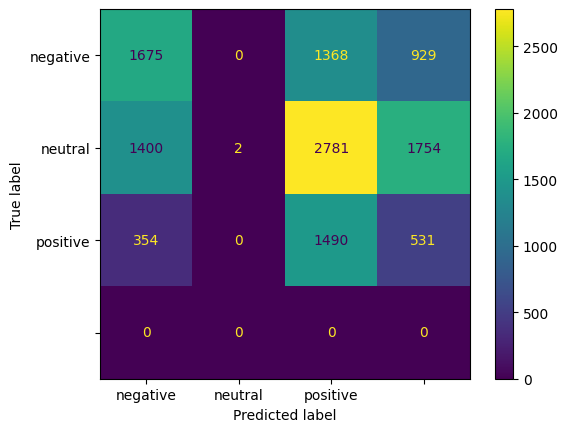

In [ ]:
initial_f1 = eval(model, dataset["test"], tokenizer)
print(f"Initial Macro F1: {initial_f1:.2f}")

# LoRA: [Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

В традиционном fine-tuning больших языковых моделей требуется обновление огромного числа параметров, что приводит к высоким вычислительным затратам и потреблению памяти. Метод LoRA решает эту проблему, вводя низкоранговые обновления весов.

Пусть $(W_0 \in \mathbb{R}^{d \times k})$ - исходная матрица весов модели. При адаптации модели предполагается, что обновление весов можно аппроксимировать матрицей низкого ранга:
$$
\Delta W = BA, \quad B \in \mathbb{R}^{d \times r}, \quad A \in \mathbb{R}^{r \times k},
$$
где $r \ll \min(d, k)$.

Обновлённая матрица весов записывается как:
$$
W = W_0 + \Delta W = W_0 + B A.
$$

Основная идея заключается в том, чтобы заморозить исходные параметры $W_0$ и обучать только матрицы $A$ и $B$. Это существенно уменьшает число обучаемых параметров, так как их суммарное количество равно $r \times (d+k)$ по сравнению с $d \times k$ для полной матрицы $W$.

Матрицу $A$ рекомендуется инициализировать нормальным распределением $N(0, \frac{1}{\sqrt{r}})$, а матрицу $B$ нулями. Также не забывайте про скейлинг $\Delta Wx$ на $\frac{\alpha}{r}$, где $\alpha$ гипер-параметр. Во время обучения его можно зафиксировать $\alpha=16$.

## Адаптиация модели с LoRA слоями [2 балла]

В этом задачнии вам потребуется:
1. Дописать класс `LoRALayer` который заменит слои модели
2. Дописать функцию рекурсивного обхода модели, чтобы применить к ней `LinearWithLoRA`
3. Обновить модель

In [ ]:
import math
class LoRALayer(nn.Module):
    """Implements a low-rank adaptation layer for a linear transformation.
    This layer introduces a trainable low-rank update to the input tensor.

    Attributes:
        B (nn.Parameter): A weight matrix of shape (in_dim, rank), initialized to zeros.
        A (nn.Parameter): A weight matrix of shape (rank, out_dim), initialized with random values
                          scaled by 1/sqrt(rank).
        alpha (float): A scaling factor for the low-rank update.
        scaling (float): Pre-calculated scaling factor (alpha / rank).
    """

    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        # Коэффициент масштабирования, как указано в статье LoRA
        self.scaling = alpha / rank

        # B: Проекция вниз (in -> rank). Инициализируем нулями.
        # Это гарантирует, что в начале обучения вклад LoRA равен 0 (identity init).
        self.B = nn.Parameter(torch.zeros(in_dim, rank))

        # A: Проекция вверх (rank -> out). Инициализируем нормальным распределением.
        # Масштабируем дисперсию на 1/sqrt(rank).
        self.A = nn.Parameter(torch.randn(rank, out_dim) * (1 / math.sqrt(rank)))

    def forward(self, x):
        # x: [batch_size, in_dim]
        # x @ B -> [batch_size, rank]
        # (x @ B) @ A -> [batch_size, out_dim]
        # Результат умножаем на scaling factor

        # Важно привести x к типу весов (например, если используем mixed precision)
        x = x.to(self.B.dtype)
        return self.scaling * (x @ self.B @ self.A)


class LinearWithLoRA(nn.Module):
    """Combines a standard linear layer with a LoRA (Low-Rank Adaptation) layer.
    The forward pass returns the sum of the output of the linear layer and the low-rank update.

    Attributes:
        linear (nn.Module): The original linear layer.
        lora (LoRALayer): The low-rank adaptation layer configured with matching input and output dimensions.
    """

    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear

        # Замораживаем веса исходного линейного слоя
        self.linear.weight.requires_grad = False
        if self.linear.bias is not None:
            self.linear.bias.requires_grad = False

        # Создаем LoRA слой с теми же размерностями
        self.lora = LoRALayer(
            in_dim=linear.in_features,
            out_dim=linear.out_features,
            rank=rank,
            alpha=alpha
        )

    def forward(self, x):
        # Суммируем выход замороженной модели и обучаемой ветки LoRA
        # y = W0x + BAx * (alpha/r)
        return self.linear(x) + self.lora(x)

In [ ]:
def apply_peft_to_module(model, adapter_class, r, alpha, target_submodules):
    """Recursively applies a parameter-efficient fine-tuning (PEFT) adapter to target submodules within a model."""

    # Получаем имена всех дочерних модулей текущего блока
    for name, child in model.named_children():

        # Проверяем условие замены:
        # 1. Имя модуля содержит одну из целевых строк (например, "q_proj" в "layers.0.self_attn.q_proj")
        # 2. Модуль является линейным слоем (nn.Linear), так как LoRA применяется именно к ним
        if any(target in name for target in target_submodules) and isinstance(child, nn.Linear):

            # Создаем обертку с LoRA, передавая исходный слой и параметры ранга/альфа
            # adapter_class здесь — это наш LinearWithLoRA
            wrapped_layer = adapter_class(child, r, alpha)

            # Заменяем старый слой на новый внутри родительской модели
            setattr(model, name, wrapped_layer)

        else:
            # Если текущий слой не подходит для замены,
            # мы рекурсивно заходим внутрь него, чтобы проверить его "детей"
            apply_peft_to_module(child, adapter_class, r, alpha, target_submodules)

### Применим наш LoRA adapter к нашей модели

Обычно для дешевого обучения достаточно применить LoRA к слоям для ключей `k_proj` и значений `v_proj`. Однако, если вы уверены в своих действиях, то не воспрещается обучать и другие слои с помощью LoRA :)

In [ ]:
# Примените peft к модели
apply_peft_to_module(model, LinearWithLoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model = model.to(DEVICE)

In [ ]:
def freeze_layers(model, patterns):
    for name, param in model.named_parameters():
        # Если имя параметра содержит хотя бы одну подстроку из patterns (например, "lora"),
        # мы разрешаем обучение. Иначе — замораживаем.
        if any(pattern in name for pattern in patterns):
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Блок подсчета статистики параметров (из вашего кода)
    total_params, trainable_params = 0, 0
    for name, param in model.named_parameters():
        # Можно раскомментировать print, если нужно проверить конкретные слои
        # print(f"{name}: {param.requires_grad}")

        param_count = np.prod(param.shape)
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count

    print(f"Train {trainable_params}/{total_params} ({trainable_params / total_params * 100:.2f}%) parameters")

    return model

# Применяем функцию: оставляем обучаемыми только параметры, содержащие "lora" в названии
model = freeze_layers(model, ["lora"])

Train 430080/300031872 (0.14%) parameters


## Обучение [1 балл]

*Напутствие:*
Пришло время приступить к обучению модели. После реализации train loop вы заслужите перерыв на 30+ минут – отличный повод с гордостью заявить, что вы заняты обучением модели. Однако длительность отдыха остаётся на ваше усмотрение. Мы рекомендуем ограничиться 2–3 эпохами файнтюна, чтобы избежать излишних вычислительных затрат и переобучения модели.

Обратите внимание, что вам предстоит реализовать классический train loop на PyTorch. Здесь у вас достаточно свободы для выбора гиперпараметров (`batch_size`, `lr`, `num_epochs`). Вы можете использовать дополнительные гиперпараметры на свое усмотрение, например, для оптимизатора.

Чтобы пройти испытание, нужно набрать не менее 0.5 F1. Да прибудет с вами сила ✋

In [ ]:
def pad_collate_fn(batch: list[dict[str, torch.Tensor]], pad_token_id: int) -> dict[str, torch.Tensor]:
    """
    Collates a batch of tokenized examples into padded tensors.
    Fixes 'list object has no attribute clone' by converting lists to tensors.
    """

    # 1. Сразу конвертируем списки в тензоры для input_ids
    # Важно указать dtype=torch.long, так как это индексы токенов
    full_input_ids_list = [torch.tensor(item["full_input_ids"], dtype=torch.long) for item in batch]

    # 2. Формируем labels
    labels_list = []
    for item in batch:
        # Конвертируем в тензоры
        full_input = torch.tensor(item["full_input_ids"], dtype=torch.long)
        prompt_input = torch.tensor(item["input_ids"], dtype=torch.long)

        label = full_input.clone()

        # Маскируем промпт
        prompt_len = len(prompt_input)
        if prompt_len < len(label):
            label[:prompt_len] = -100
        else:
            label[:] = -100

        labels_list.append(label)

    # 3. Паддинг (функция pad ожидает список тензоров — теперь у нас все верно)
    padded_input_ids = pad(full_input_ids_list, padding_value=pad_token_id, padding_side="left")
    padded_labels = pad(labels_list, padding_value=-100, padding_side="left")

    # 4. Attention Mask
    attention_mask = (padded_input_ids != pad_token_id).long()

    return {
        "input_ids": padded_input_ids,
        "attention_mask": attention_mask,
        "labels": padded_labels
    }

In [ ]:
dataloader = DataLoader(
    dataset["train"],
    batch_size=2,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
next(iter(dataloader))

{'input_ids': tensor([[32000, 32000, 32000, 32000,     1, 32001,  1587,    13,  1976,   460,
            264, 10865, 13892,   369,   875,  8961,   272, 21790,   302,  9394,
           1468, 28723,  1094,  8910,  1374,   272,  9394,   299,  3857,   486,
            272,  2188,   304,  7655,   513,   272, 21790,   349,   464,  1065,
           2468,   647,   464, 23806,  1650,   647,   442,   464, 23238,  4135,
          26307,   395,   272,  3870,   865, 28723, 32000, 28705,    13, 32001,
           2188,    13, 28818,  1838, 24992, 20523,   624,   302,   272,  1722,
            369,  2499, 10332,   286,   993,   506,  4067, 12642,  4187,   262,
            356,   559, 19340,  6207, 32000, 28705,    13, 32001, 13892,    13,
          23238, 32000, 28705,    13],
         [    1, 32001,  1587,    13,  1976,   460,   264, 10865, 13892,   369,
            875,  8961,   272, 21790,   302,  9394,  1468, 28723,  1094,  8910,
           1374,   272,  9394,   299,  3857,   486,   272,  2188,   

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import torch

def train_model(model, optimizer, train_dataloader, val_dataset, num_epochs):
    # 1. Используем GradScaler для ускорения (Mixed Precision)
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0

        # Прогресс-бар для эпохи
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

        for step, batch in enumerate(progress_bar):
            # Перенос данных на GPU
            batch = {k: (v.to(model.device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}

            optimizer.zero_grad()

            # 2. Оптимизация: autocast (fp16)
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Обратное распространение через scaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if step % 50 == 0 and step > 0:
                avg_loss = running_loss / 50
                progress_bar.set_postfix({'loss': avg_loss})
                running_loss = 0.0

        # 3. Оптимизация валидации:
        # Полная генерация (eval) на 2000 примерах занимает ОЧЕНЬ много времени.
        # Лучше делать это на маленькой выборке (например, 50-100 примеров)
        print("Validating on subset...")
        val_subset = val_dataset.select(range(50)) # Берем только 50 примеров для скорости
        val_f1 = eval(model, val_subset, tokenizer, show_conf_m=False)
        print(f"Epoch {epoch + 1} | Validation F1 (subset): {val_f1:.4f}")

    # 4. ВАЖНО: Возвращаем модель, иначе model станет None!
    return model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
from functools import partial

# 1. ВОССТАНОВЛЕНИЕ МОДЕЛИ 
print("Reloading model...")
MODEL_NAME = "OuteAI/Lite-Oute-1-300M-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Применяем DoRA 
apply_peft_to_module(model, LinearWithLoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model = model.to(DEVICE)

# Замораживаем слои (кроме lora/dora)
model = freeze_layers(model, ["lora"])

# 2. НАСТРОЙКА ОБУЧЕНИЯ
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
NUM_EPOCHS = 1

train_dataloader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
    pin_memory=True,
    num_workers=2
)


optimizer = torch.optim.AdamW([p for n, p in model.named_parameters() if "lora" in n], lr=LEARNING_RATE)

# 3. ЗАПУСК ОБУЧЕНИЯ
print("Starting training...")
model = train_model(model, optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

Reloading model...


Loading weights:   0%|          | 0/183 [00:00<?, ?it/s]

Train 430080/300031872 (0.14%) parameters
Starting training...


/tmp/ipython-input-454489221.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1:   0%|          | 0/1426 [00:00<?, ?it/s]

/tmp/ipython-input-454489221.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating on subset...


Batching examples:   0%|          | 0/50 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 | Validation F1 (subset): 0.5526


In [ ]:
model = train_model(model, optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

/tmp/ipython-input-454489221.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1:   0%|          | 0/1426 [00:00<?, ?it/s]

/tmp/ipython-input-454489221.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating on subset...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 | Validation F1 (subset): 0.5324


In [ ]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
positive 
positive 
positive 
pos
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
neutral 
neutral 
neutral 
neut
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
neutral 
neutral 
neutral 
neut
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
neutral 
neutral 
neutral 
neut
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
neutral 
neutral 
neutral 
neut


## Оценим результаты

Теперь увидим, как повлиял наш файнтюнинг

  0%|          | 0/123 [00:00<?, ?it/s]

After LoRA Macro F1: 0.53


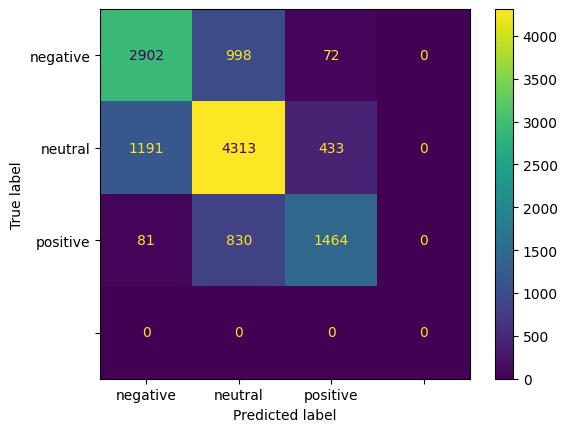

In [ ]:
after_lora_f1 = eval(model, dataset["test"], tokenizer)
print(f"After LoRA Macro F1: {after_lora_f1:.2f}")

In [ ]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-lora", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-lora", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ziz0oh5/model.safetensors:   3%|2         | 33.5MB / 1.20GB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw3-lora/commit/1f1f5dc11506ec8dcb020417866271b97dcd238c', commit_message='Upload tokenizer', commit_description='', oid='1f1f5dc11506ec8dcb020417866271b97dcd238c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw3-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw3-lora'), pr_revision=None, pr_num=None)

In [ ]:
# Очистим память
gc.collect()
torch.cuda.empty_cache()

## DoRA: [Weight-Decomposed Low-Rank Adaptation](https://arxiv.org/abs/2402.09353)

В отличие от метода LoRA, где обновление весов модели представлено в виде низкорангового произведения, метод DoRA вводит дополнительную степень гибкости за счёт применения диагональной матрицы для весового масштабирования.

Пусть $W_0 \in \mathbb{R}^{d \times k}$ - исходная матрица весов. В DoRA обновление весов определяется следующим образом:
$$
W = m \frac{W_0 + BA}{\|W_0 + BA \|}
$$

Где $BA$ соответствует использованию LoRA, а $m \in \mathbb{R}^{k}$ обучаемый вектор.

## Обучение модели с помощью DoRA [4 балла]

В этом задании вам потребуется:
1. Написать с нуля класс `LinearWithDoRA` который использует написанный ранее `LoRALayer` класс
2. Применить его к модели
3. Обучить модель

Чтобы пройти испытание, нужно набрать не менее 0.5 F1.

In [ ]:
import torch.nn.functional as F
class LinearWithDoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.rank = rank
        self.alpha = alpha

        # 1. Замораживаем веса исходного слоя
        self.linear.weight.requires_grad = False
        if self.linear.bias is not None:
            self.linear.bias.requires_grad = False

        # 2. Инициализируем LoRA слой (используем класс из предыдущего задания)
        # ВАЖНО: B и A нужны нам для явного вычисления матрицы весов
        self.lora = LoRALayer(
            in_dim=linear.in_features,
            out_dim=linear.out_features,
            rank=rank,
            alpha=alpha
        )

        # 3. Инициализируем вектор магнитуды m
        # Он должен совпадать по размерности с выходными фичами (количество нейронов)
        # Инициализируем его текущей нормой весов предобученной модели,
        # чтобы обучение начиналось с исходного состояния.
        # linear.weight shape: [out_features, in_features]
        # Вычисляем норму по dim=1 (по вектору входящих весов для каждого нейрона)
        with torch.no_grad():
            self.m = nn.Parameter(self.linear.weight.norm(p=2, dim=1, keepdim=True))

    def forward(self, x):
        # 1. Получаем матрицу добавки LoRA: delta W = (B @ A).T * scaling
        # Транспонируем, так как PyTorch хранит веса как [out, in], а LoRA у нас (in->rank->out)
        lora_update = (self.lora.B @ self.lora.A).T * self.lora.scaling

        # 2. Складываем с замороженными весами: V = W0 + delta W
        # Приводим типы к одному виду (например, если W0 в bf16, а lora в fp32)
        weight_v = self.linear.weight.to(lora_update.dtype) + lora_update

        # 3. Нормализуем V, чтобы получить направление: V / ||V||
        # Добавляем eps для стабильности, чтобы не делить на 0
        weight_norm = weight_v.norm(p=2, dim=1, keepdim=True) + 1e-6
        weight_direction = weight_v / weight_norm

        # 4. Применяем магнитуду: W_new = m * direction
        new_weight = self.m * weight_direction

        # 5. Выполняем линейное преобразование: y = x @ W_new.T + bias
        return F.linear(x, new_weight, self.linear.bias)

Сбрасываем модель и применяем наш DoRA адаптер

In [ ]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

apply_peft_to_module(model, LinearWithDoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model = model.to(DEVICE)
model = freeze_layers(model, ["lora"])

Loading weights:   0%|          | 0/183 [00:00<?, ?it/s]

Train 430080/300049792 (0.14%) parameters


### Обучение

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
NUM_EPOCHS = 3

train_dataloader = DataLoader(
    dataset["train"].take(10_000),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

optimizer = torch.optim.AdamW(
    [p for n, p in model.named_parameters() if "lora" in n], lr=LEARNING_RATE, weight_decay=0.01
)

In [ ]:
model = train_model(model, optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

/tmp/ipython-input-454489221.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipython-input-454489221.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating on subset...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 | Validation F1 (subset): 0.5386


Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipython-input-454489221.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating on subset...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 | Validation F1 (subset): 0.5592


Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipython-input-454489221.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating on subset...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 | Validation F1 (subset): 0.5633


In [ ]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
positive 
positive 
positive 
pos
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
neutral 
neutral 
neutral 
neut
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
neutral 
neutral 
neutral 
neut
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
neutral 
neutral 
neutral 
neut
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
neutral 
neutral 
neutral 
neut


  0%|          | 0/123 [00:00<?, ?it/s]

After DoRA Macro F1: 0.51


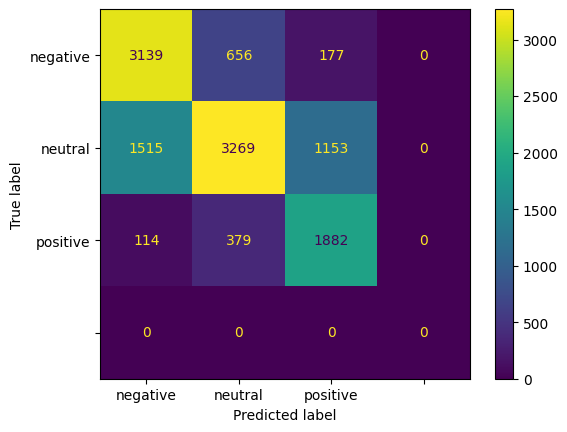

In [ ]:
after_dora_f1 = eval(model, dataset["test"], tokenizer)
print(f"After DoRA Macro F1: {after_dora_f1:.2f}")

Для качественного обучения доры в этой задаче нужно постараться.
Будем считать, что если качество > 0.5, то задание с учетом правильности кода решено верно

In [ ]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-dora", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-dora", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...z06wnwd/model.safetensors:   3%|2         | 33.5MB / 1.20GB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw3-dora/commit/b79fa5d654c4b7693a62539d0a92ad9b3858c705', commit_message='Upload tokenizer', commit_description='', oid='b79fa5d654c4b7693a62539d0a92ad9b3858c705', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw3-dora', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw3-dora'), pr_revision=None, pr_num=None)

In [ ]:
# Очистим память
gc.collect()
torch.cuda.empty_cache()

## Frameworks way [2 балла]

### QLoRA: [Efficient Finetuning of Quantized LLMs](https://arxiv.org/pdf/2305.14314)

Метод QLoRA направлен на эффективное дообучение предварительно обученных больших языковых моделей с использованием квантования весов. Основная идея заключается в том, что во время обратного распространения ошибки модель квантует исходные веса с точностью до 4 бит, что позволяет значительно сократить использование GPU памяти. Для обработки пиков памяти при этом применяются страничные оптимизаторы.

В результате, применение QLoRA часто приводит к экономии GPU памяти примерно на $\dfrac{1}{3}$, однако время обучения при этом может увеличиться почти на $\dfrac{1}{4}$ по сравнению с традиционными методами дообучения.

Такой компромисс между экономией памяти и увеличением времени обучения делает QLoRA привлекательным решением в сценариях, где ресурсы ограничены, а эффективность использования памяти критически важна.

Теперь с таким прекрасным инструментом как QLoRA можем рассмотреть более тяжелую модель аж 1.1B :)

Используйте документацию библиотек [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) и [PEFT](https://huggingface.co/docs/peft/index).

1. Конфигурация квантизации (`BitsAndBytesConfig`): Подберите тип 4-битной квантизации (`bnb_4bit_quant_type`) и размерность подсчёта (`bnb_4bit_compute_dtype`)

2. Настройка LoRA-адаптеров (`LoraConfig`):
    - Подберите и обоснуйте значения следующих гиперпараметров:
        - `lora_alpha`
        - `lora_dropout`
        - `r`
    - Выберите модули модели, к которым следует применять LoRA-адаптеры (`target_modules`).

3. Настройка параметров обучения (`TrainingArguments`, `SFTTrainer`):
Используя документацию и подберите параметры:
    - `learning_rate`
    - `num_train_epochs`
    - `gradient_accumulation_steps`
    - `lr_scheduler_type`
    - `per_device_train_batch_size`
    - другие параметры по необходимости

4. Проведение обучения и анализ результатов:
    - Запустите обучение модели.
    - Оцените модель до и после обучения.
    - сохраните модель


Чтобы пройти испытание, нужно набрать не менее 0.5 F1.


In [ ]:
LARGE_MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Заведем конфиг для квантизации
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    # nf4 (NormalFloat4) оптимален для нормально распределенных весов LLM
    bnb_4bit_quant_type="nf4",
    # Вычисления делаем в float16 для скорости
    bnb_4bit_compute_dtype=torch.float16,
    # Двойное квантование экономит еще немного памяти
    bnb_4bit_use_double_quant=True,
)

# Инициализация квантованной модели
model = AutoModelForCausalLM.from_pretrained(LARGE_MODEL_NAME, quantization_config=bnb_config)
model = model.to(DEVICE)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [17]:
tokenizer = AutoTokenizer.from_pretrained(LARGE_MODEL_NAME)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [18]:
for split, data in dataset.items():
    dataset[split] = data.map(process_example, fn_kwargs={"tokenizer": tokenizer})
    dataset[split] = data.map(tokenization, batched=True, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|i

Batching examples:   0%|          | 0/12284 [00:00<?, ? examples/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Initial F1 large model: 0.18


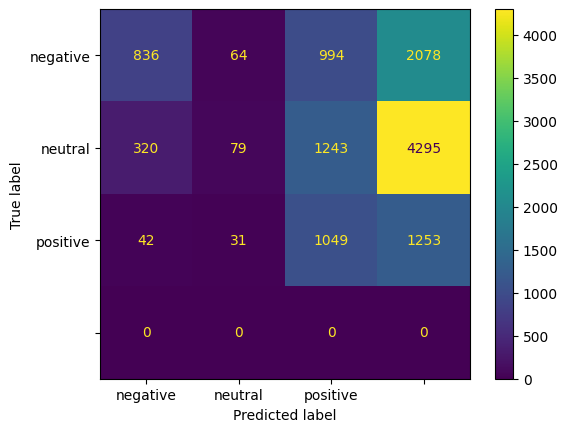

In [19]:
initial_f1_large_model = eval(model, dataset["test"], tokenizer)
print(f"Initial F1 large model: {initial_f1_large_model:.2f}")

### Обучим QLoRA

In [20]:
peft_config = LoraConfig(
    lora_alpha=32,    # Обычно берется alpha = 2 * r. Это скейлинг обновлений.
    lora_dropout=0.05, # Небольшой дропаут для регуляризации
    r=16,             # Ранг матрицы. 16 — отличный баланс скорость/качество для 1B модели.
    bias="none",
    task_type="CAUSAL_LM",
    # Для Llama-подобных архитектур лучше всего обучать все линейные проекции:
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

`SFTTrainer` supports conversational format:
```
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "..."}]}
```

In [21]:
def convert_instruction_format(example, system_prompt=SYSTEM_PROMPT):
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Text: {example['text']}"},
        {"role": "assistant", "content": example["str_label"]},
    ]
    return {"messages": conversation}


sft_dataset = dataset.copy()
for split, data in dataset.items():
    sft_dataset[split] = data.map(
        convert_instruction_format,
        remove_columns=["text", "label", "str_label", "prompt", "full_prompt", "input_ids", "full_input_ids"],
    )

for i in range(2):
    for k, v in sft_dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

messages: [{'content': "You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.", 'role': 'system'}, {'content': 'Text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'role': 'user'}, {'content': 'positive', 'role': 'assistant'}]
messages: [{'content': "You are a helpful assistant that classifies the sentiment of tweets. Analyze the tweet provided by the user and determine if the sentiment is 'positive', 'neutral', or 'negative'. Answer with the label only.", 'role': 'system'}, {'content': 'Text: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'role': 'user'}, {'content': 'neutral', 'role': 'assistant'}]


In [ ]:
training_arguments = TrainingArguments(
    output_dir="./results",
    # --- УСКОРЕНИЕ ---
    per_device_train_batch_size=64,       
    gradient_accumulation_steps=1,       
    gradient_checkpointing=False,        # ОТКЛЮЧИЛИ: дает +30-40% к скорости для малых моделей
    dataloader_num_workers=4,            
    dataloader_pin_memory=True,          # Ускоряет передачу данных CPU -> GPU
    # -----------------

    num_train_epochs=3,
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    optim="paged_adamw_32bit",
    weight_decay=0.01,
    fp16=False,
    bf16=True,                           # Оставляем BFloat16
    logging_steps=10,
    group_by_length=True,
    report_to="none"
)
# Оставляем, например, только первые 10000 примеров для обучения
# Это кардинально ускорит процесс
if len(sft_dataset["train"]) > 10000:
    sft_dataset["train"] = sft_dataset["train"].select(range(10000))
trainer = SFTTrainer(
    model=model,
    train_dataset=sft_dataset["train"],
    args=training_arguments,      
    processing_class=tokenizer,
)

trainer.train()

Tokenizing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if 

Step,Training Loss
10,2.667298
20,2.242592
30,1.423375
40,0.829250
50,1.201979
60,1.041945
70,0.916788
80,0.806424
90,1.114836
100,1.006810


Step,Training Loss
10,2.667298
20,2.242592
30,1.423375
40,0.829250
50,1.201979
60,1.041945
70,0.916788
80,0.806424
90,1.114836
100,1.006810


TrainOutput(global_step=471, training_loss=0.971318866543456, metrics={'train_runtime': 11705.8331, 'train_samples_per_second': 2.563, 'train_steps_per_second': 0.04, 'total_flos': 2.133899558800589e+16, 'train_loss': 0.971318866543456})

Starting evaluation with padding_side='left'...


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


  0%|          | 0/123 [00:00<?, ?it/s]

QLoRA F1 large model: 0.31


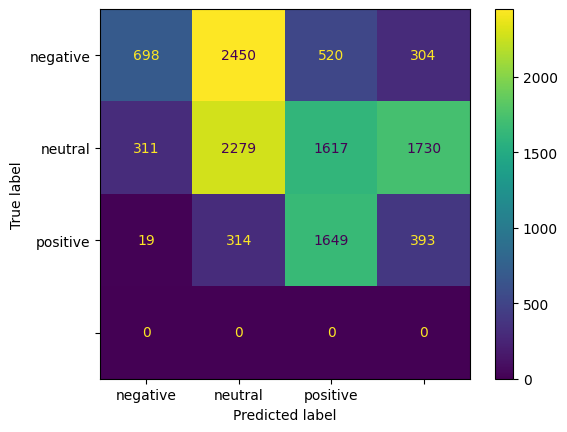

In [ ]:
# 1. СНАЧАЛА настраиваем токенизатор и модель для генерации (Eval)
tokenizer.padding_side = "left"  
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# Переводим в режим оценки
model.eval()

# 2. ТЕПЕРЬ определяем и проверяем smart_predict (уже с правильным паддингом)
import re

def smart_predict(text, model, tokenizer):
    messages = [{"role": "user", "content": f"Text: {text}\nSentiment:"}]
    input_ids = tokenizer.apply_chat_template(
        [
         {"role": "system", "content": "Classify the sentiment of the text. Return only one word: positive, negative, or neutral."},
         {"role": "user", "content": f"Text: {text}"}
        ],
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.inference_mode():
        outputs = model.generate(
            input_ids,
            max_new_tokens=5,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )

    response = tokenizer.decode(outputs[0][input_ids.shape[1]:], skip_special_tokens=True)

    # Чистка
    response = response.lower().strip()
    response = response.replace("sentiment:", "").replace(".", "")
    match = re.search(r'\b(positive|negative|neutral)\b', response)
    if match:
        return match.group(1)
    return "neutral"

# Быстрый тест глазами — работает ли модель вообще?
print("--- TEST PREDICTION ---")
print(f"Input: {dataset['test'][0]['text'][:50]}...")
print(f"Prediction: {smart_predict(dataset['test'][0]['text'], model, tokenizer)}")
print("-----------------------")

# 3. НАКОНЕЦ запускаем полную оценку (eval)
print("Starting full evaluation...")

# Контекстный менеджер для защиты от ошибок SDPA
with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=False):
    qlora_large_model = eval(model, dataset["test"], tokenizer)

print(f"QLoRA F1 large model: {qlora_large_model:.2f}")

In [24]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-tinyllama-qlora", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-tinyllamma-qlora", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   2%|2         |  615kB / 25.3MB            

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw3-tinyllamma-qlora/commit/58b88946647b9c68a408c3f17d1abdfc6eaee239', commit_message='Upload tokenizer', commit_description='', oid='58b88946647b9c68a408c3f17d1abdfc6eaee239', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw3-tinyllamma-qlora', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw3-tinyllamma-qlora'), pr_revision=None, pr_num=None)

# Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Оформить репозитории на 🤗 (можно сделать коллекцию, так как у нас 3 репозитория): карточка модели с описанием задания, репортом качества и примерами генерации **[0.5 балла]**

# Специальный раздел для проверяющего

## LoRA

In [ ]:
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download

model = AutoModelForCausalLM.from_pretrained(f"{REPO_NAME}-lora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(f"{REPO_NAME}-lora")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Примените peft к модели
apply_peft_to_module(model, LinearWithLoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model.to(DEVICE)

path = hf_hub_download(f"{REPO_NAME}-lora", "model.safetensors")
state_dict = load_file(path)

model.load_state_dict(state_dict, strict=False)

LoRA_saved_model_accuracy = eval(model, dataset["test"], tokenizer)
print(f"Accuracy after LoRA training: {LoRA_saved_model_accuracy:.2f}")

## DoRA

In [ ]:
model = AutoModelForCausalLM.from_pretrained(f"{REPO_NAME}-dora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(f"{REPO_NAME}-dora")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

apply_peft_to_module(model, LinearWithDoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model.to(DEVICE)

path = hf_hub_download(f"{REPO_NAME}-dora", "model.safetensors")
state_dict = load_file(path)

model.load_state_dict(state_dict, strict=False)

DoRA_saved_model_accuracy = eval(model, dataset["test"], tokenizer)
print(f"Accuracy after DoRA training: {DoRA_saved_model_accuracy}")

## QLoRA

In [ ]:
model = AutoModelForCausalLM.from_pretrained(f"{REPO_NAME}-tinyllama-qlora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(f"{REPO_NAME}-tinyllama-qlora")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

QLoRA_saved_model_accuracy = eval(model, dataset["test"], tokenizer)
print(f"Accuracy after tinyllama QLoRA training: {QLoRA_saved_model_accuracy}")